In [54]:
import imageio
from skimage.transform import resize
from analyzer.data import Dataloader
import glob
import h5py
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from skimage.measure import regionprops

In [40]:
gt_path = "../datasets/r_gt/"
em_path = "../datasets/r_em/"

dl = Dataloader(gtpath=gt_path, volpath=em_path)
regions = dl.prep_data_info()
region = regions[0]

In [41]:
all_fn = sorted(glob.glob(gt_path + '*.' + "png"))

fns = [all_fn[id] for id in region['slices']]
first_image_slice = imageio.imread(fns[0])
mask = np.zeros(shape=first_image_slice.shape, dtype=np.uint16)
mask[first_image_slice == region['id']] = 1
volume = mask

for fn in fns[1:]:
    image_slice = imageio.imread(fn)
    mask = np.zeros(shape=image_slice.shape, dtype=np.uint16)
    mask[image_slice == region['id']] = 1
    volume = np.dstack((volume, mask))
volume = np.moveaxis(volume, -1, 0)

In [51]:
mito_region= regionprops(volume)[0]
mito_volume = volume[mito_region.bbox[0]:mito_region.bbox[3] + 1,
              mito_region.bbox[1]:mito_region.bbox[4] + 1,
              mito_region.bbox[2]:mito_region.bbox[5] + 1].astype(np.float32)

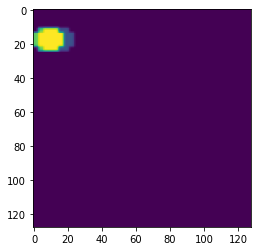

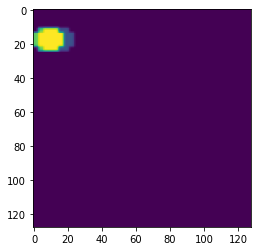

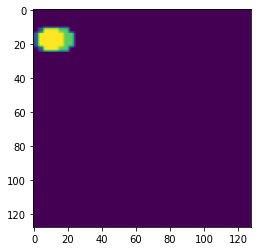

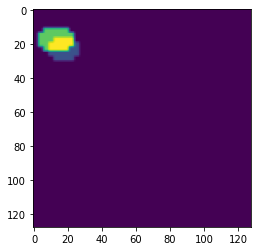

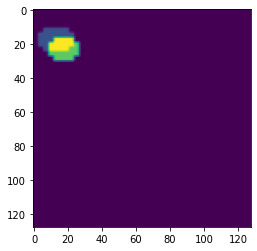

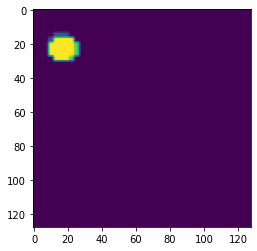

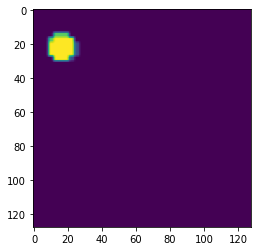

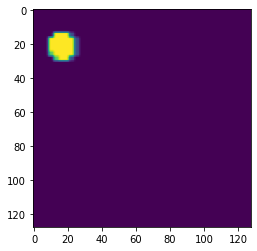

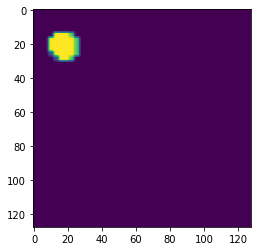

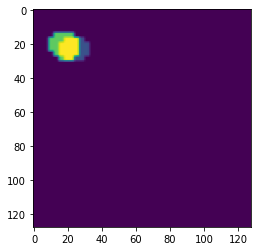

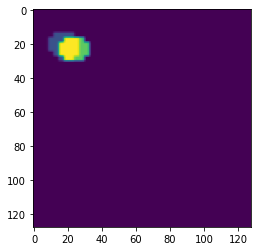

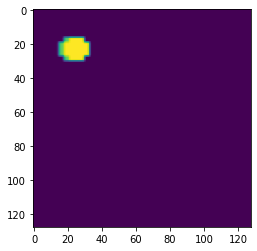

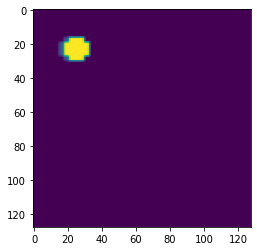

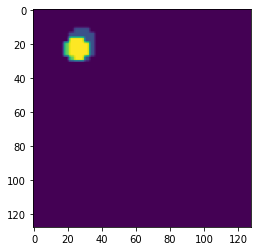

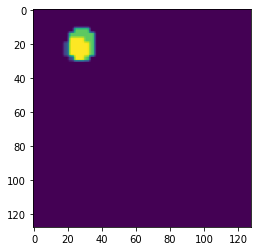

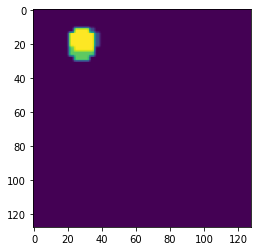

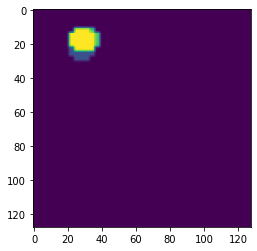

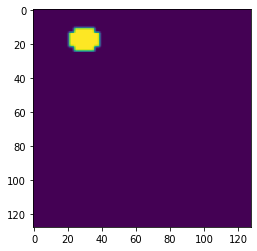

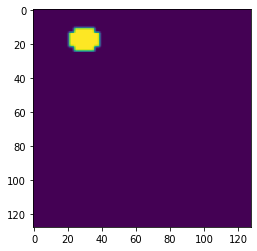

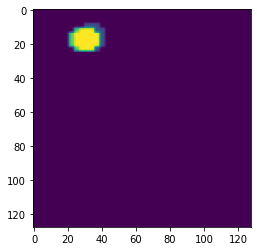

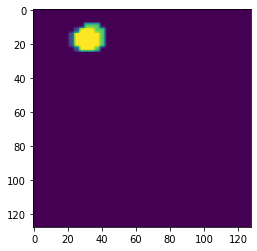

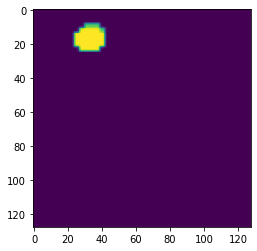

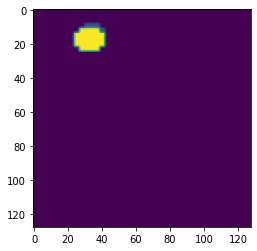

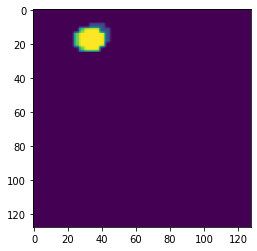

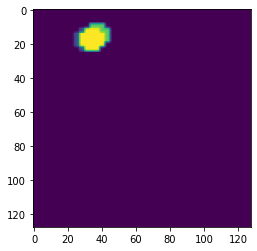

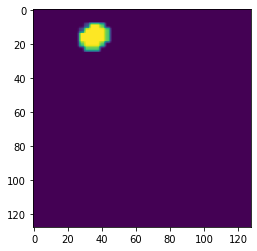

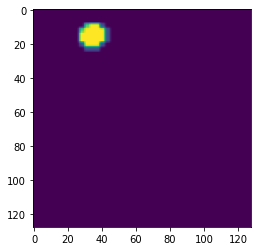

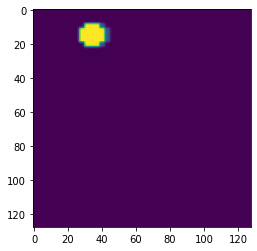

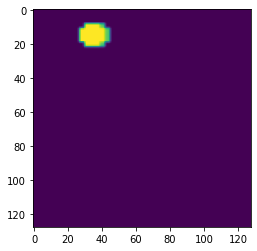

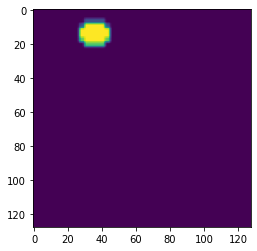

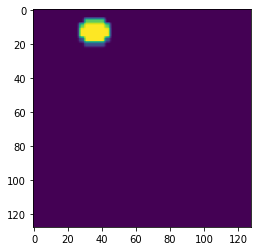

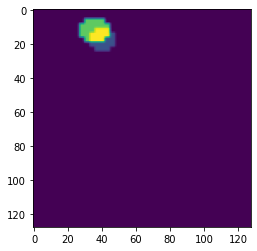

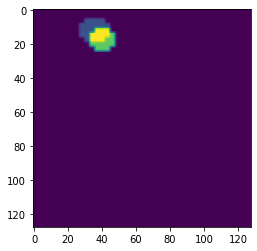

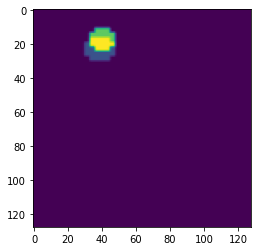

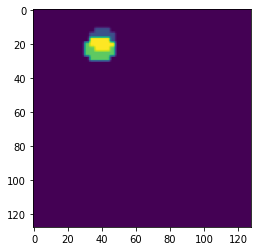

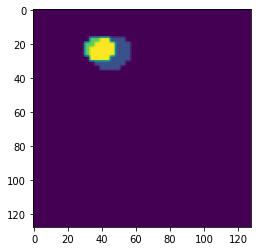

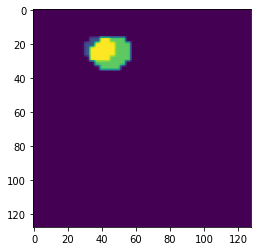

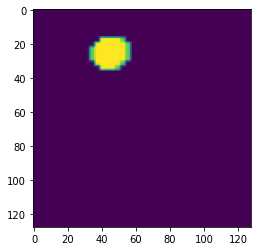

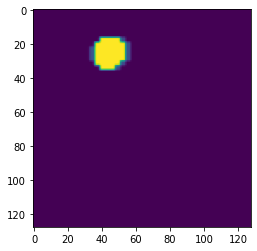

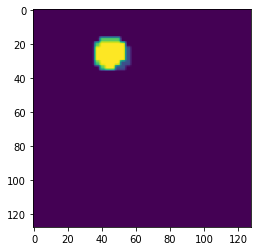

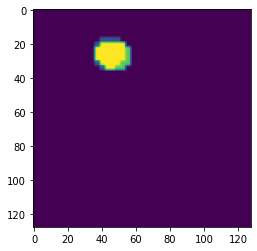

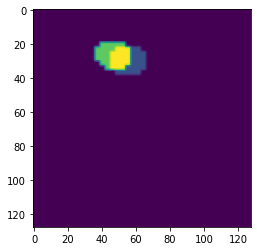

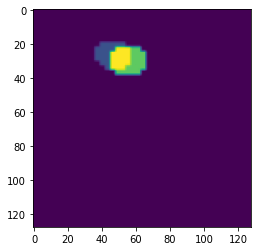

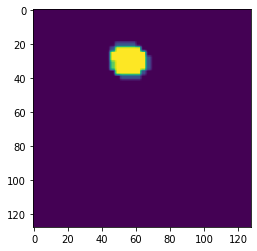

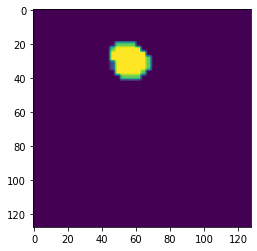

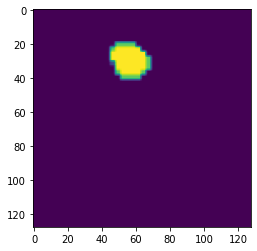

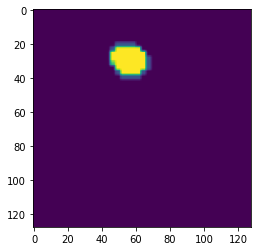

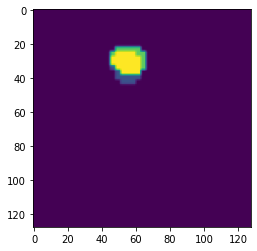

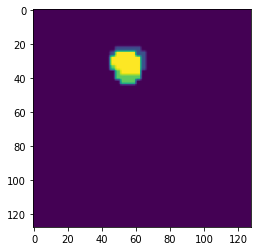

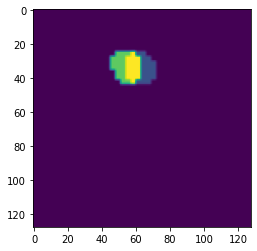

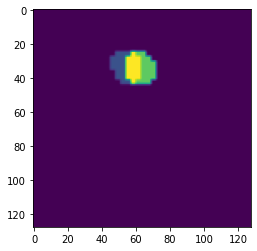

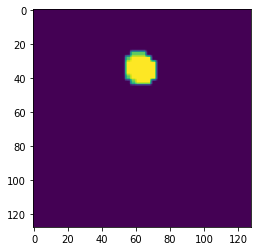

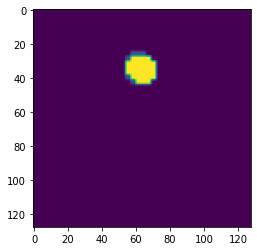

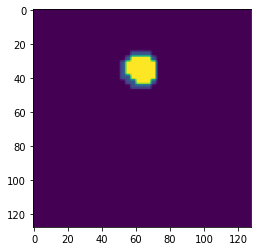

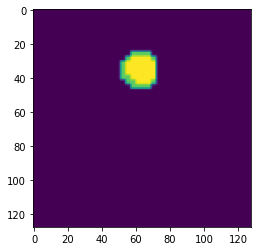

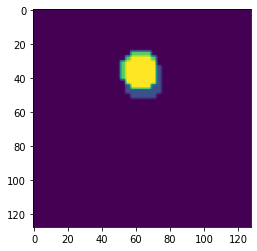

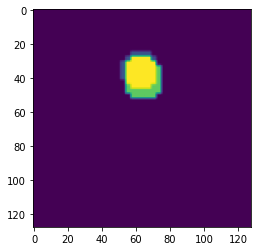

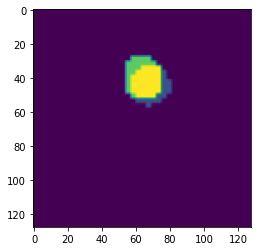

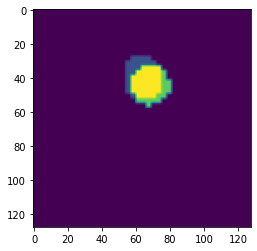

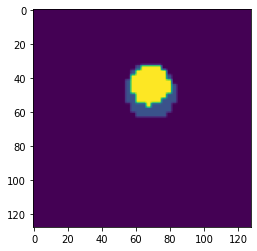

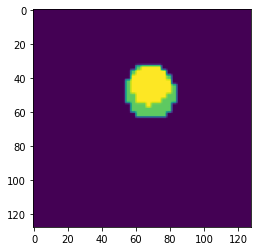

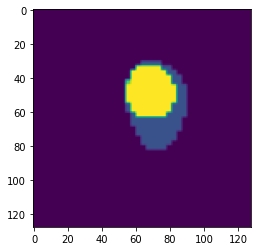

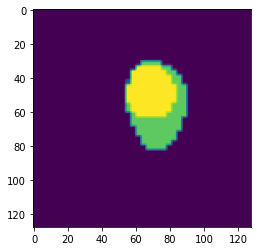

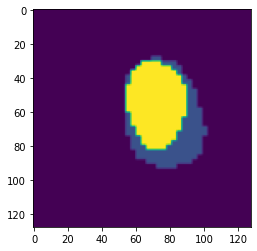

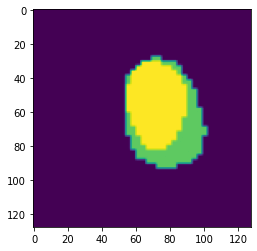

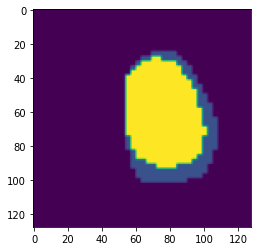

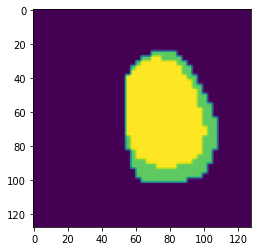

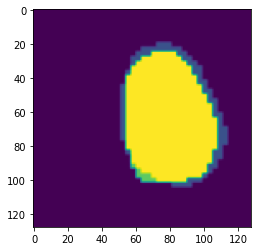

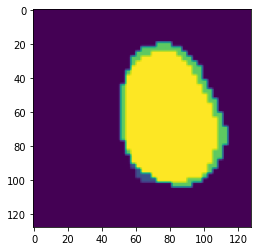

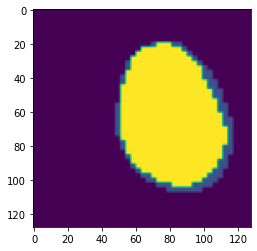

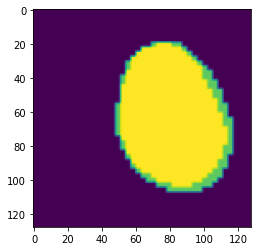

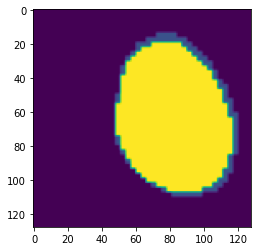

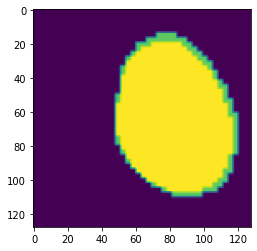

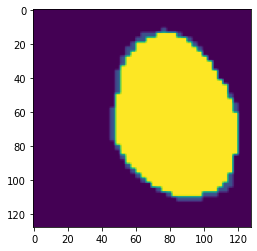

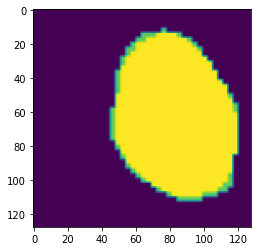

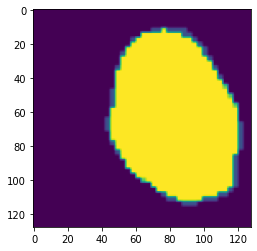

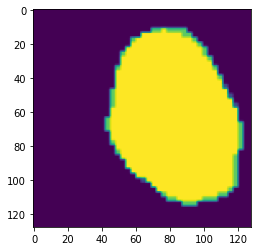

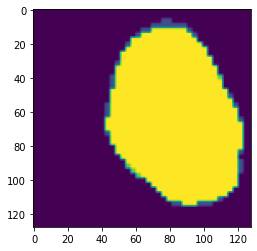

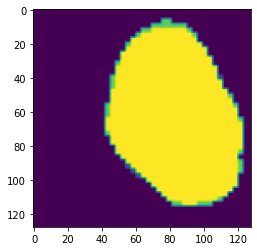

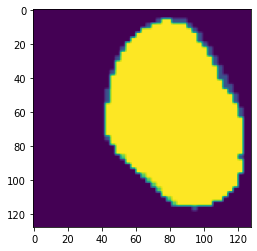

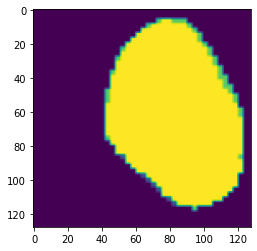

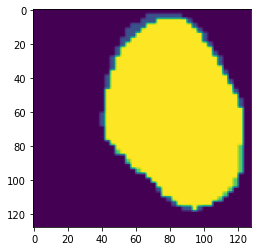

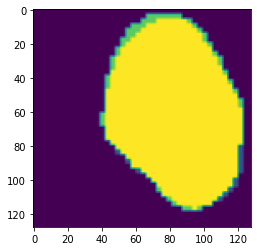

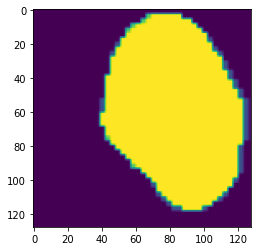

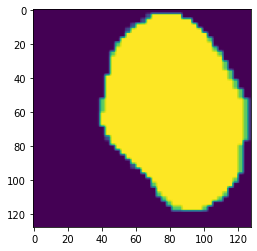

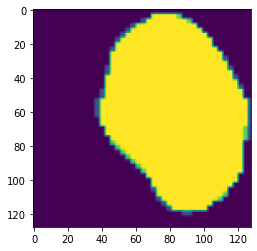

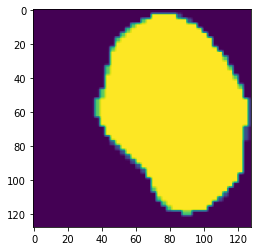

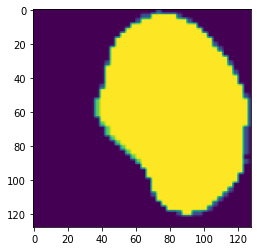

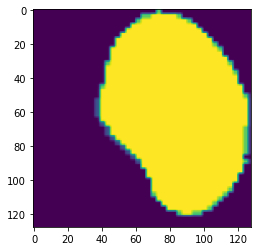

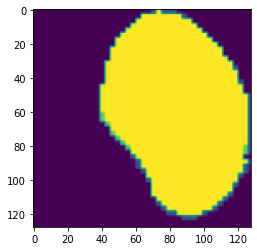

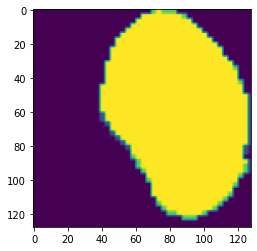

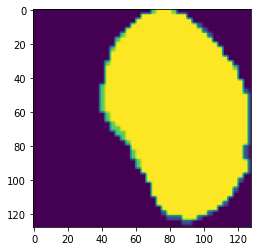

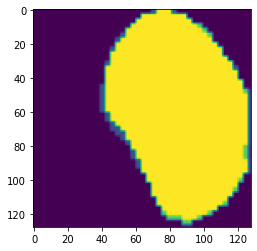

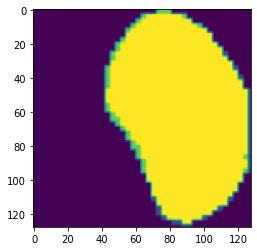

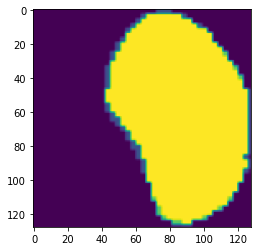

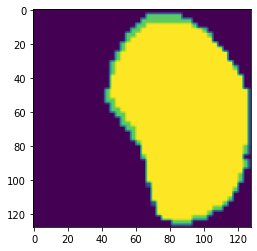

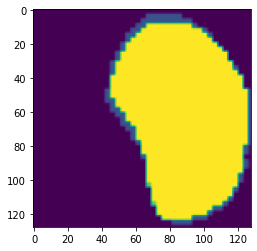

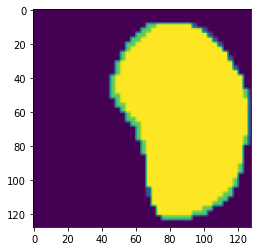

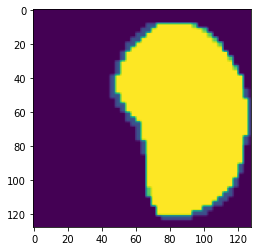

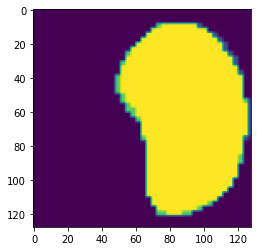

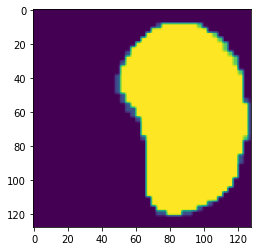

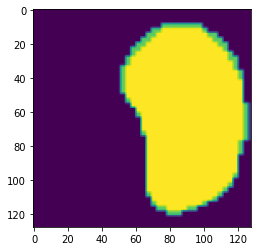

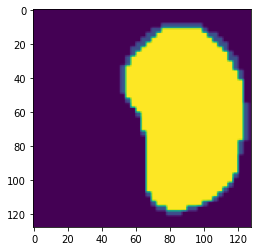

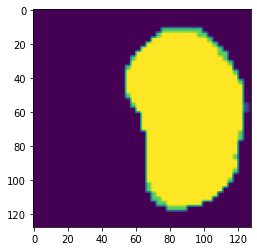

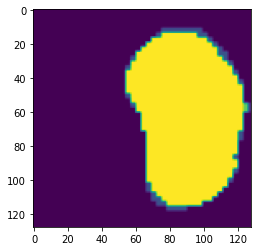

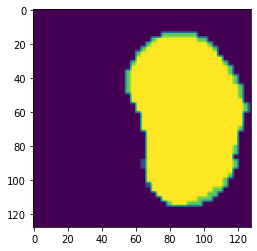

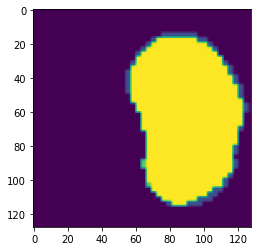

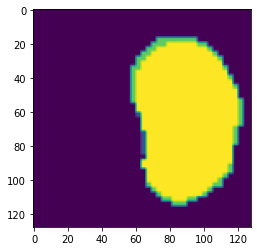

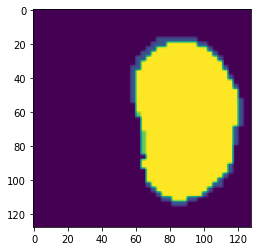

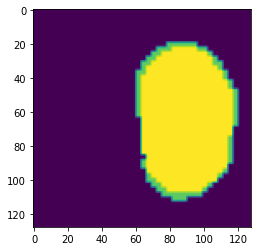

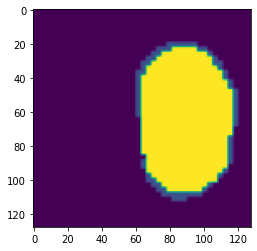

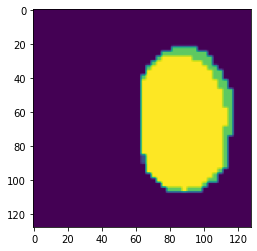

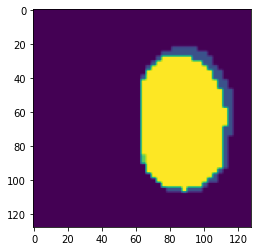

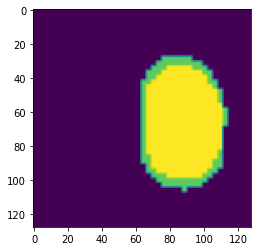

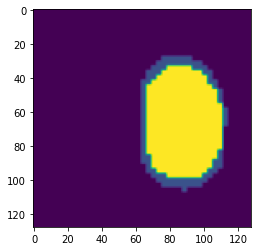

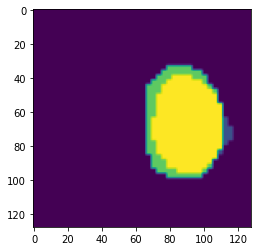

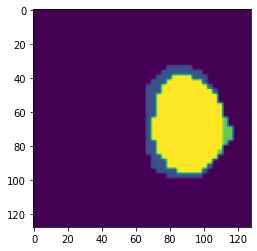

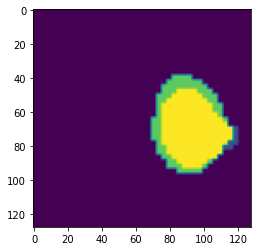

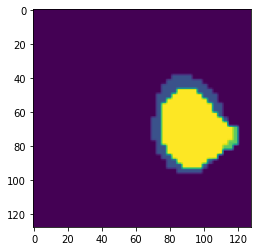

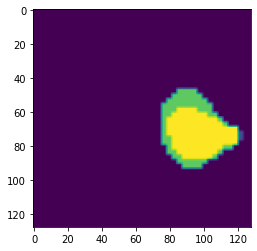

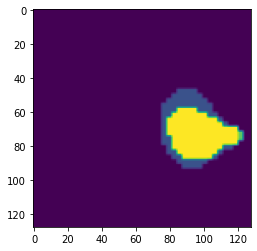

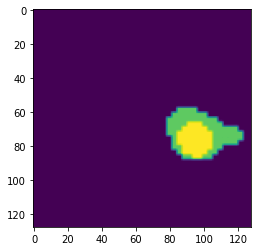

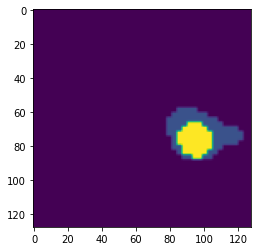

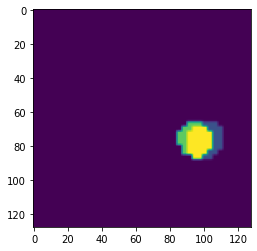

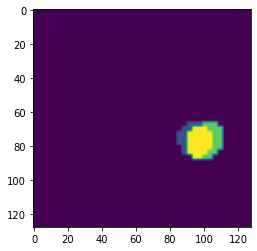

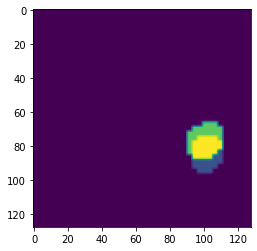

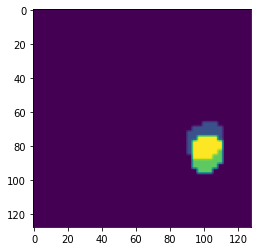

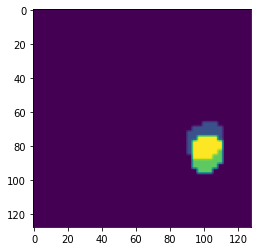

In [56]:
scaled_mito = resize(mito_volume,(128,128,128))
for slice in scaled_mito:
    plt.imshow(slice)
    plt.show()

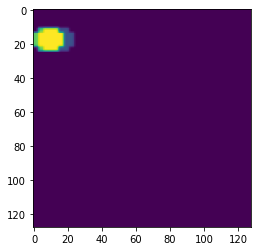

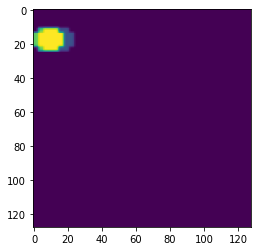

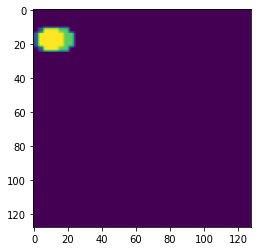

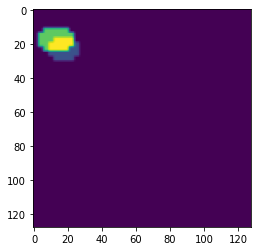

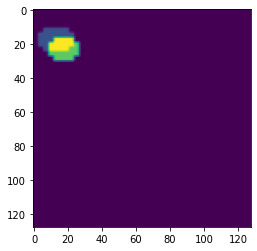

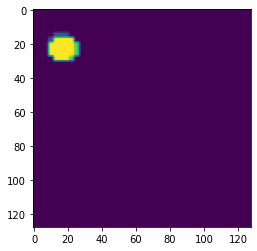

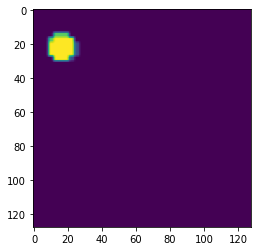

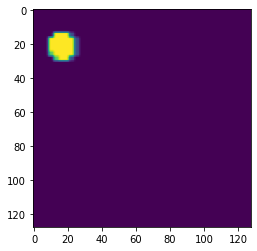

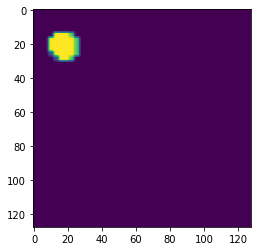

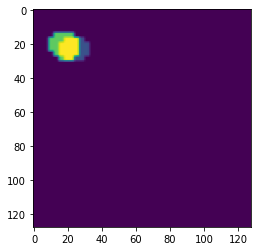

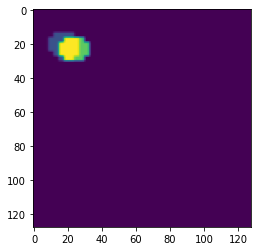

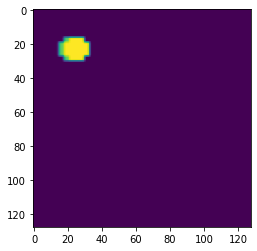

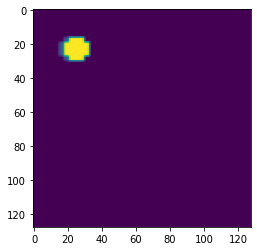

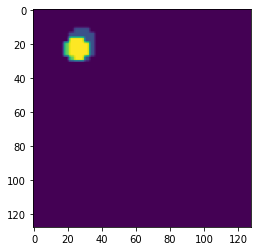

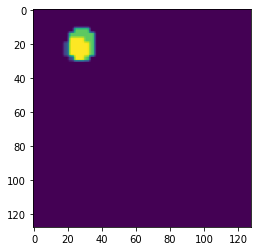

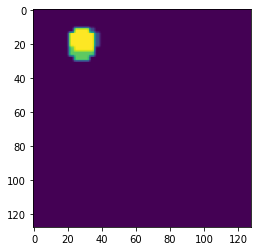

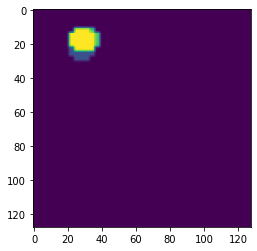

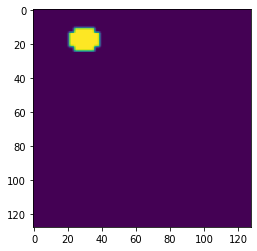

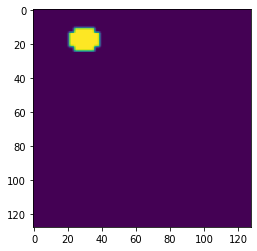

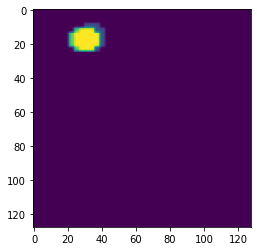

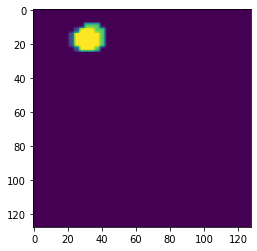

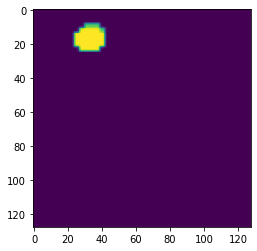

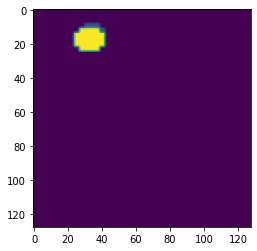

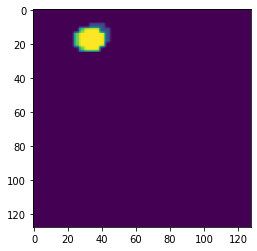

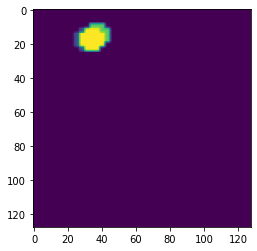

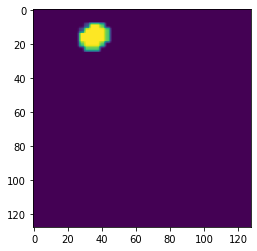

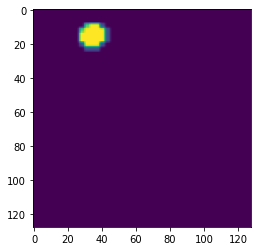

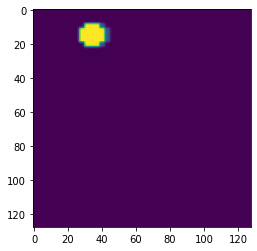

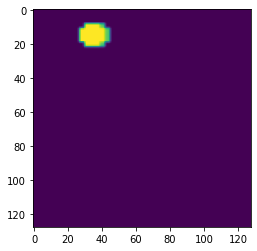

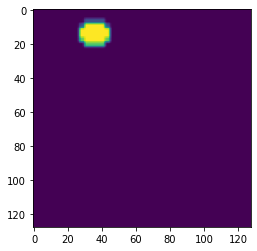

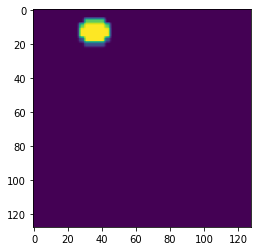

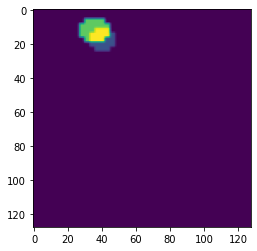

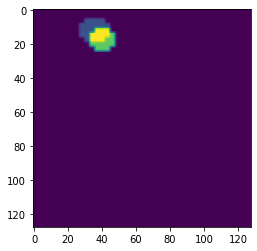

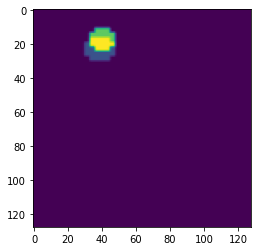

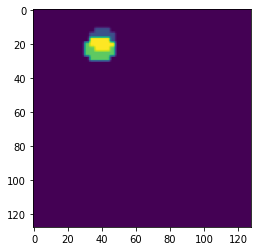

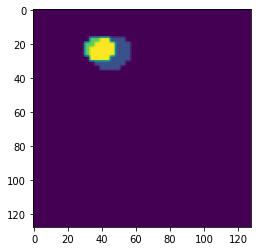

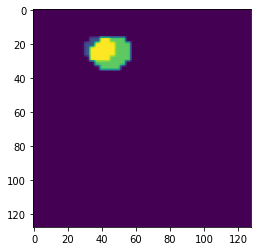

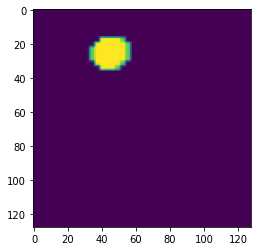

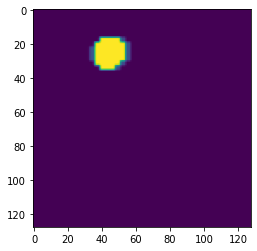

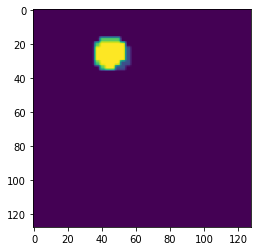

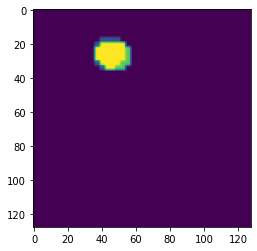

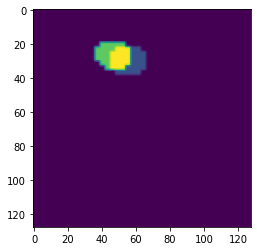

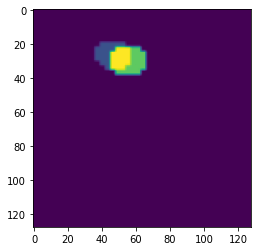

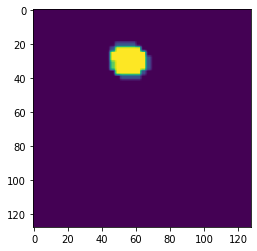

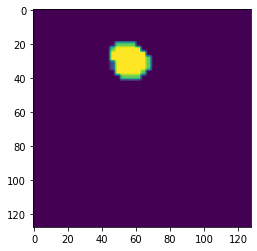

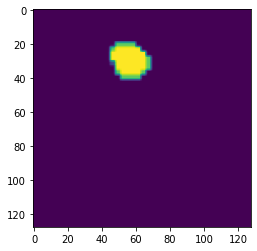

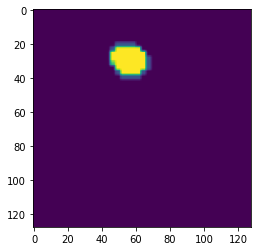

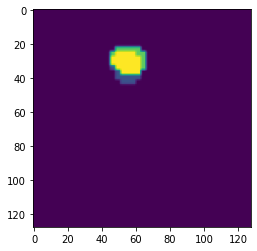

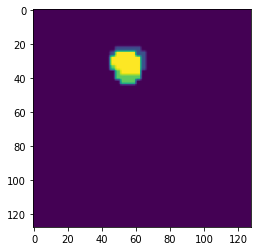

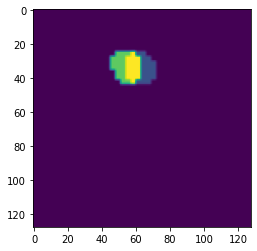

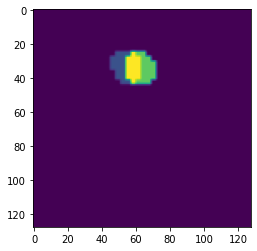

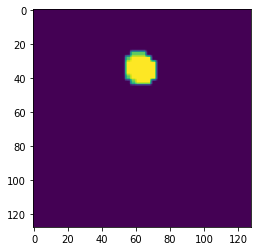

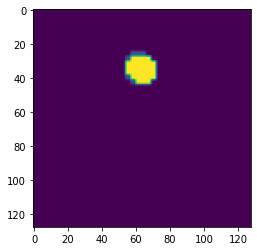

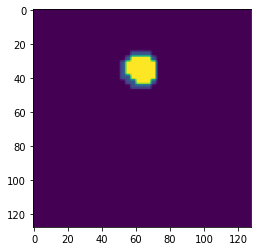

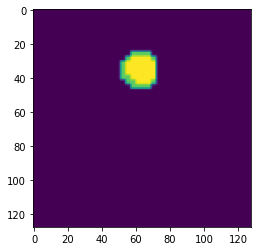

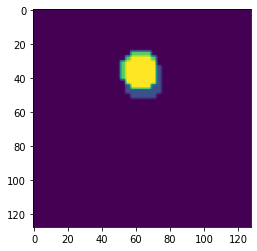

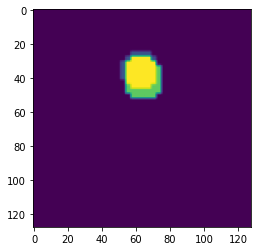

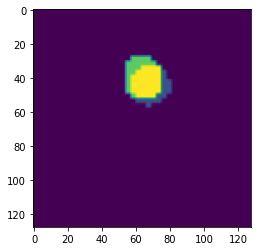

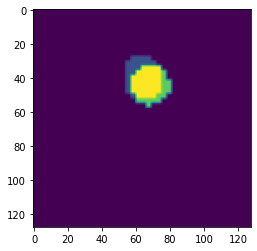

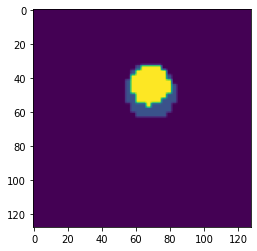

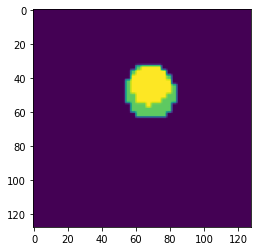

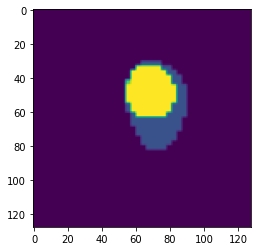

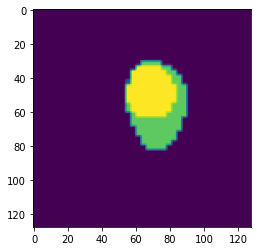

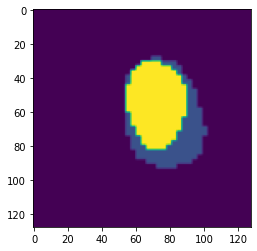

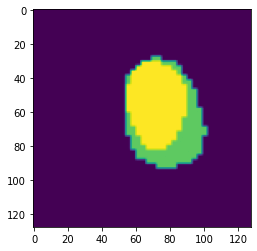

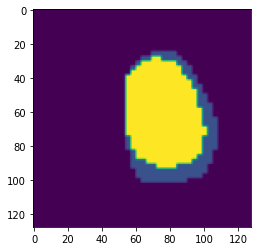

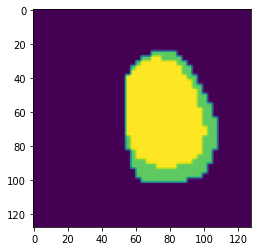

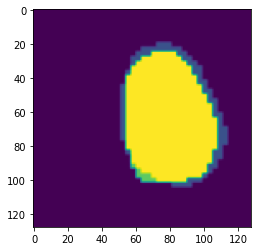

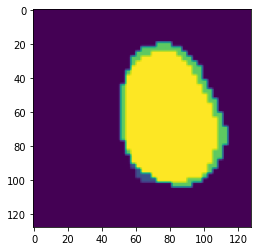

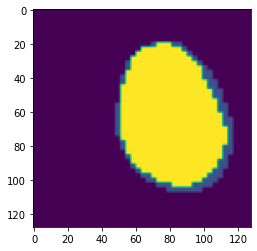

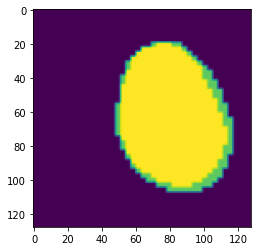

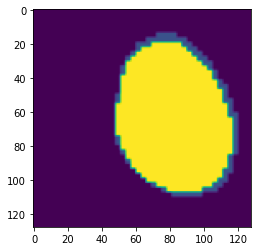

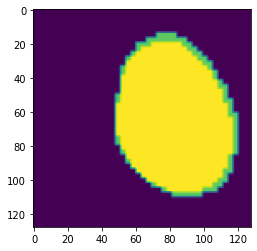

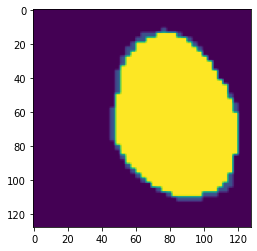

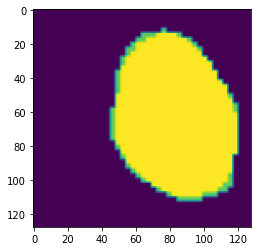

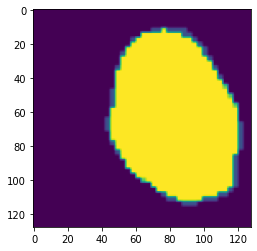

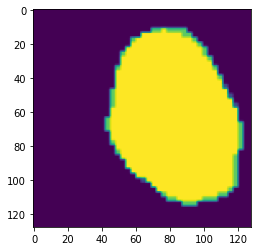

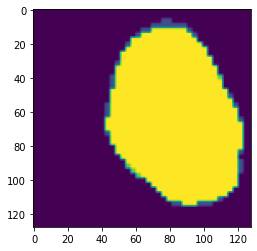

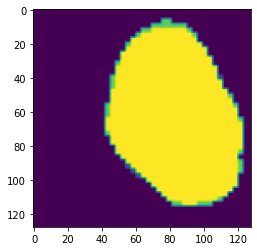

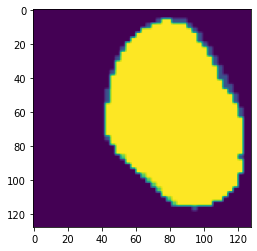

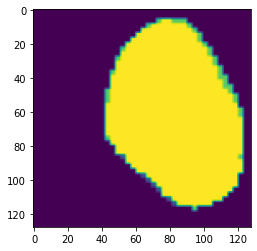

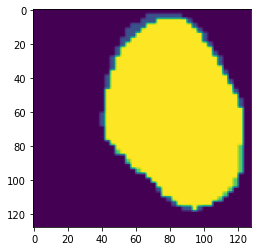

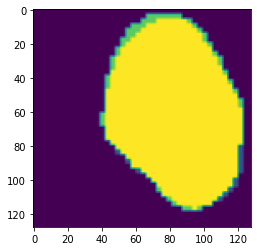

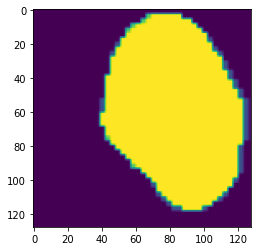

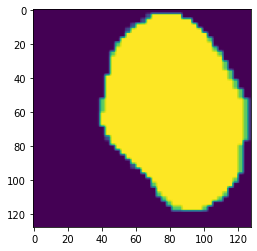

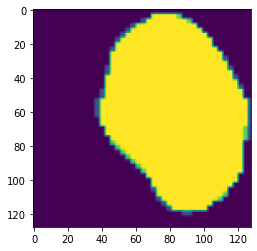

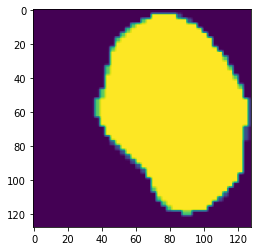

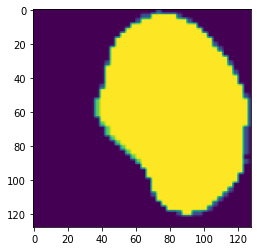

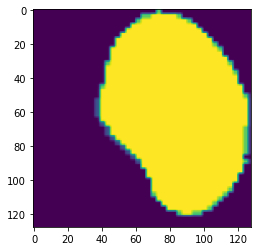

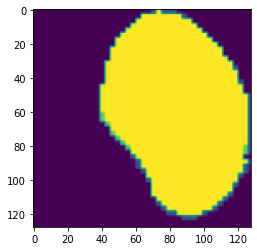

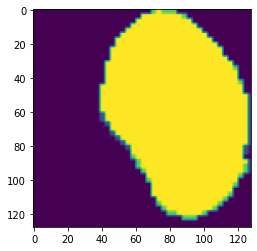

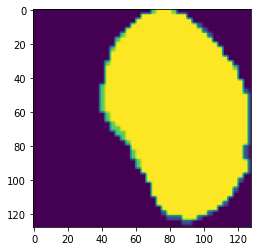

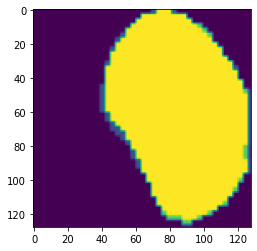

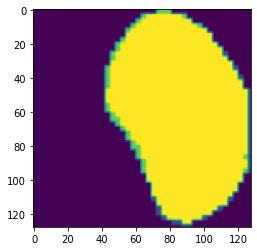

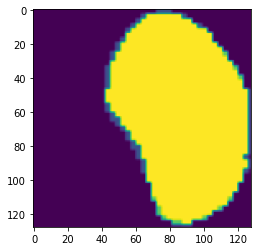

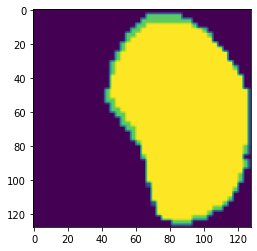

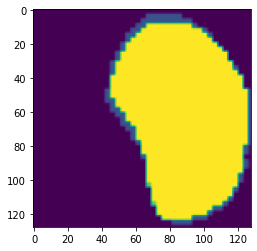

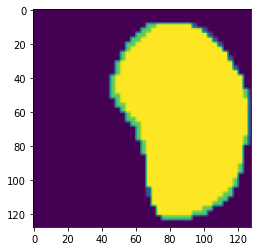

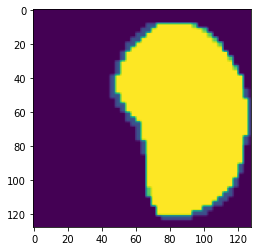

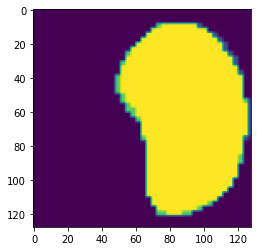

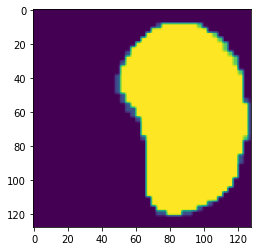

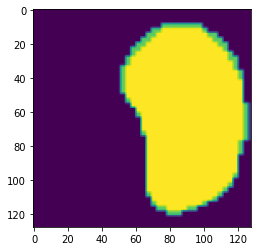

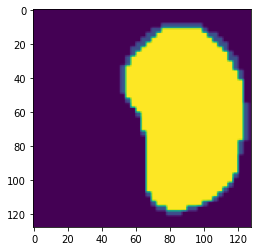

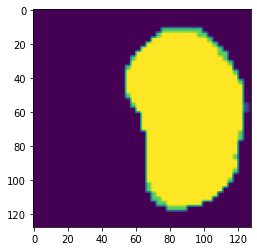

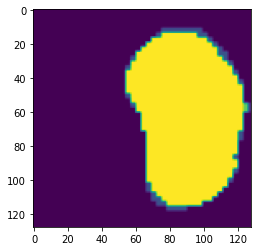

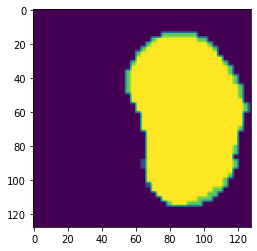

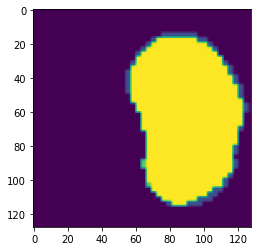

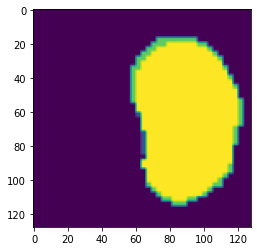

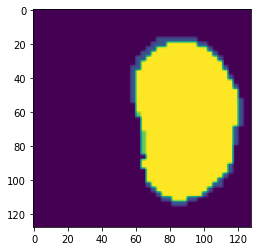

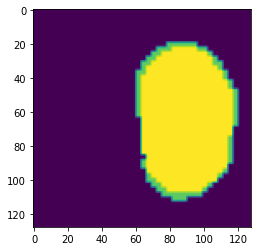

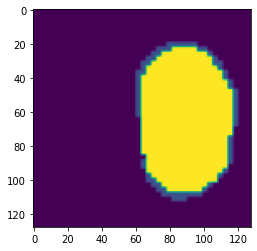

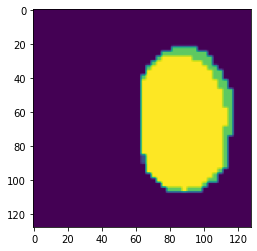

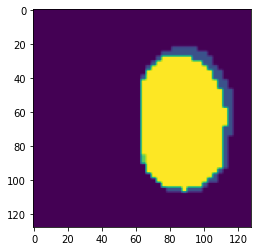

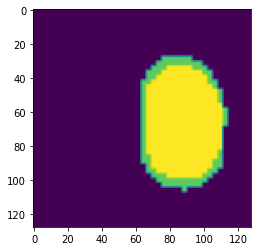

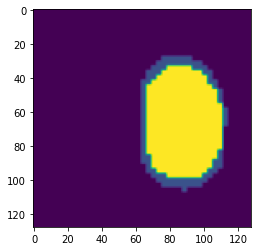

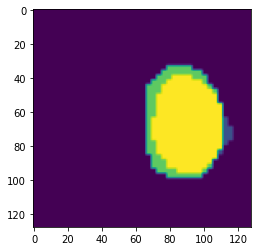

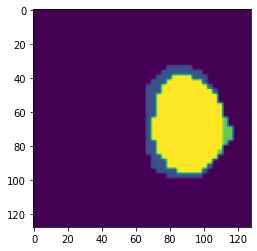

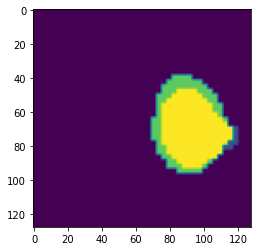

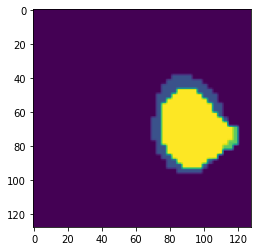

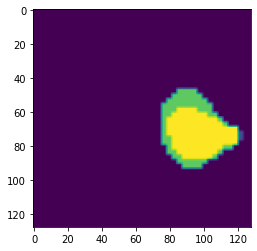

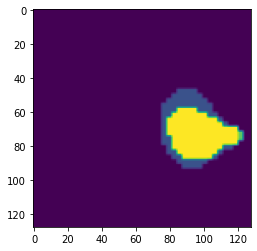

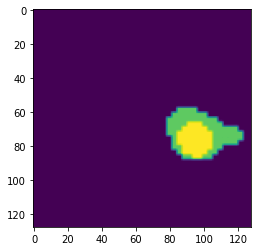

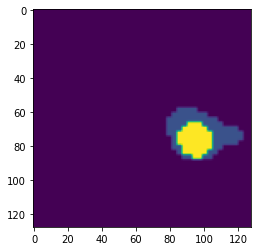

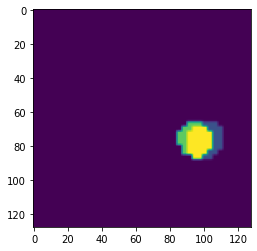

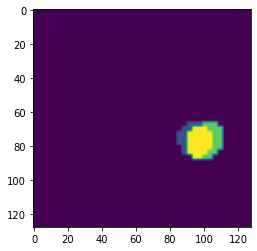

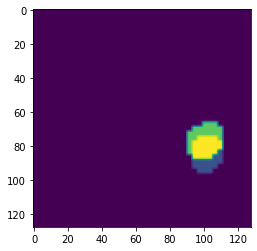

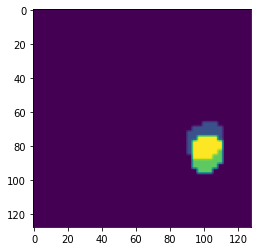

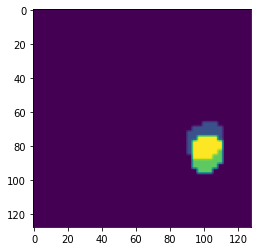

In [61]:
with h5py.File('../features/mito.h5', 'r') as f:
    dset = f['mito_volumes']
    for i in range(0,128):
        plt.imshow(dset[0][0][i])
        plt.show()